# **Imports**

In [1]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score, r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.random import set_seed
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.regularizers import L1, L2
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [3]:
# setting plots style
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})

# **Data** **Preparation**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_train = pd.read_csv('/content/drive/My Drive/df_train_processed.csv')
df_test = pd.read_csv('/content/drive/My Drive/df_test_processed.csv')

In [6]:
df_train.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,frame_count,sum,mean,...,stft_std_w4,stft_min_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,speech,neutral,normal,Kids are talking by the door,1st,1,M,158558,0.145081,9.150000e-07,...,0.155455,0.000000,0.000000,0.566462,0.709962,0.799141,0.896606,1.0,6.742190,-1.706215
1,speech,neutral,normal,Kids are talking by the door,2nd,1,M,160160,0.114319,7.137790e-07,...,0.163183,0.270133,0.368623,0.472736,0.623183,0.744908,0.874713,1.0,-0.700420,-0.201495
2,speech,neutral,normal,Dogs are sitting by the door,1st,1,M,156956,0.149963,9.554485e-07,...,0.190634,0.000000,0.000000,0.417919,0.643636,0.774253,0.899156,1.0,1.688986,-1.024773
3,speech,neutral,normal,Dogs are sitting by the door,2nd,1,M,152152,0.139618,9.176213e-07,...,0.182551,0.205616,0.306280,0.399641,0.606910,0.755213,0.886474,1.0,-0.594111,-0.412871
4,speech,calm,normal,Kids are talking by the door,1st,1,M,169769,0.137665,8.108948e-07,...,0.177069,0.177847,0.248765,0.428202,0.634815,0.759914,0.878014,1.0,0.126535,-0.620782


In [7]:
df_test.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,frame_count,sum,mean,...,stft_std_w4,stft_min_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,speech,neutral,normal,Kids are talking by the door,1st,19,M,161762,0.475616,2.940224e-06,...,0.169929,0.222808,0.306697,0.466157,0.645931,0.789123,0.908316,1.0,-0.260279,-0.566556
1,speech,neutral,normal,Kids are talking by the door,2nd,19,M,155355,0.120148,7.733752e-07,...,0.216928,0.114567,0.170786,0.279347,0.557524,0.733053,0.866973,1.0,-0.428900,-0.587210
2,speech,neutral,normal,Dogs are sitting by the door,1st,19,M,160160,-0.599304,-3.741909e-06,...,0.227178,0.010295,0.023285,0.305395,0.577750,0.741576,0.889984,1.0,0.626916,-0.883317
3,speech,neutral,normal,Dogs are sitting by the door,2nd,19,M,158558,-0.080383,-5.069646e-07,...,0.179467,0.241405,0.368081,0.434591,0.620144,0.776419,0.904668,1.0,-0.825144,-0.383701
4,speech,calm,normal,Kids are talking by the door,1st,19,M,176176,0.152222,8.640319e-07,...,0.189124,0.217860,0.298851,0.393112,0.623309,0.772964,0.907035,1.0,-0.536669,-0.547354


In [8]:
print(df_train.shape, df_test.shape)

(1828, 383) (624, 383)


In [9]:
# standardization (train)
df_train_num = df_train.select_dtypes(include="number").drop("actor", axis=1)
df_train_cat = df_train.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num), columns=df_train_num.columns)
df_train = pd.concat([df_train_num_scaled, df_train_cat], axis=1)

In [10]:
# standardization (test)
df_test_num = df_test.select_dtypes(include="number").drop("actor", axis=1)
df_test_cat = df_test.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_test_num_scaled = pd.DataFrame(scaler.fit_transform(df_test_num), columns=df_test_num.columns)
df_test = pd.concat([df_test_num_scaled, df_test_cat], axis=1)

In [11]:
print(df_train.shape, df_test.shape)

(1828, 382) (624, 382)


In [12]:
# one-hot encoding

df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [13]:
print(df_train.shape, df_test.shape)

(1828, 394) (624, 394)


In [14]:
X_train = df_train.drop("sc_min", axis=1).to_numpy()
y_train = df_train["sc_min"].to_numpy()
X_test = df_test.drop("sc_min", axis=1).to_numpy()
y_test = df_test["sc_min"].to_numpy()

In [15]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1828, 393) (1828,)
(624, 393) (624,)


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

In [17]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1462, 393) (1462,)
(366, 393) (366,)


# **Methods**

In [18]:
# function to create accuracy and loss plots
def plot_loss(train_loss, val_loss):
  plt.plot(train_loss, label='TR')
  plt.plot(val_loss, label='VL', linestyle='--')
  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.legend(loc='upper right')
  plt.show()

In [19]:
# function for evaluation
def evaluate(y_true, y_pred):
    scores = {}
    scores["rho"] = sp.spearmanr(y_true, y_pred)
    scores["r_squared"] = r2_score(y_true, y_pred)
    scores["mse"] = mean_squared_error(y_true, y_pred)
    scores["mae"] = mean_absolute_error(y_true, y_pred)
    return scores

# **Models**

### I

In [21]:
# function to be passed to scikeras wrapper
def build_fn(n_hidden_units, hidden_activation, learning_rate, momentum, regularizer, lambd, initializer, output_activation, seed): 
    keras.backend.clear_session()
    set_seed(seed) 

    model = Sequential()
    model.add(Dense(n_hidden_units, 
                    activation = hidden_activation, 
                    input_shape = (X_train.shape[1],),
                    kernel_regularizer =  regularizer(lambd),
                    kernel_initializer = initializer))
    model.add(Dense(1, 
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = SGD(learning_rate = learning_rate, momentum = momentum),
                  loss = "mse",
                  metrics = ["mean_squared_error"])
    return model

In [22]:
# randomized search
model = KerasRegressor(build_fn,
                       hidden_activation = "sigmoid",
                       regularizer=L2,
                       initializer="glorot_normal",
                       output_activation="linear",
                       random_state=42,
                       batch_size=32,
                       seed=42,
                       verbose=0
                       )

param_grid = {'model__n_hidden_units': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.01, .001, .1, 1],
              'model__momentum': [0, .001, .01, .1],
              'model__lambd': [0, .001, .01, .1],
              'model__seed': random.sample(range(100), 10), # to keep track of weight initialization
              'epochs': [10, 20, 50, 100, 200]
              
              }

search = RandomizedSearchCV(model, 
                            param_grid, 
                            cv=KFold(3, shuffle=True, random_state=42), 
                            verbose=1,
                            n_iter=30,
                            n_jobs=-1,
                            scoring='r2')

search.fit(X_train, y_train, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [ 6.33257871e-01 -6.08470385e+07 -8.82621814e+05 -2.02836634e+00
  5.21012522e-01 -2.55200037e+01 -1.55806611e-01 -1.30037983e+22
  2.51482002e-01  6.63117508e-03 -6.78989701e-02  2.86979952e-01
             nan             nan  1.47062139e-01 -3.66384337e-01
  6.45929225e-01  2.31871430e-01  3.83941759e-01  6.09004020e-01
  8.17477358e-02 -8.63414154e+01  7.53521375e-01  6.77969624e-01
 -3.16531729e-01  1.16123142e-01  3.77408110e-01  5.21233563e-01
 -1.48264641e+00  7.02987497e-01]
  warnings.warn(


Best score: 0.7535213748992509 
Best params {'model__seed': 73, 'model__n_hidden_units': 8, 'model__momentum': 0, 'model__learning_rate': 0.01, 'model__lambd': 0.001, 'epochs': 200}


In [42]:
keras.backend.clear_session()
set_seed(73)

model = Sequential()
model.add(Dense(8, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0.001)))
model.add(Dense(1, activation="linear", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 0.02, momentum = 0.01),
                  loss = "mse",
                  metrics = ["mean_squared_error"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 3152      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,161
Trainable params: 3,161
Non-trainable params: 0
_________________________________________________________________


In [43]:
es = EarlyStopping(monitor='val_loss', patience=20, verbose=True)

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/500
46/46 [==============================] - 1s 6ms/step - loss: 0.0848 - mean_squared_error: 0.0687 - val_loss: 0.0838 - val_mean_squared_error: 0.0678
Epoch 2/500
46/46 [==============================] - 0s 3ms/step - loss: 0.0813 - mean_squared_error: 0.0653 - val_loss: 0.0808 - val_mean_squared_error: 0.0648
Epoch 3/500
46/46 [==============================] - 0s 3ms/step - loss: 0.0792 - mean_squared_error: 0.0633 - val_loss: 0.0805 - val_mean_squared_error: 0.0646
Epoch 4/500
46/46 [==============================] - 0s 3ms/step - loss: 0.0773 - mean_squared_error: 0.0615 - val_loss: 0.0790 - val_mean_squared_error: 0.0631
Epoch 5/500
46/46 [==============================] - 0s 3ms/step - loss: 0.0755 - mean_squared_error: 0.0597 - val_loss: 0.0769 - val_mean_squared_error: 0.0611
Epoch 6/500
46/46 [==============================] - 0s 2ms/step - loss: 0.0738 - mean_squared_error: 0.0580 - val_loss: 0.0745 - val_mean_squared_error: 0.0587
Epoch 7/500
46/46 [===============

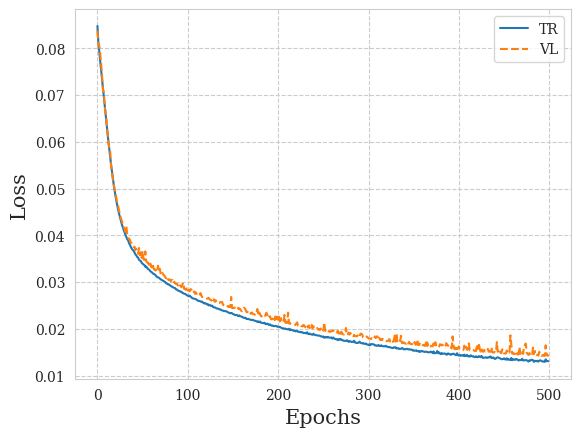

In [44]:
plot_loss(history.history['loss'], history.history['val_loss'])

In [45]:
y_pred = model.predict(X_val)
evaluate(y_val, y_pred)

12/12 [==============================] - 0s 2ms/step


{'rho': SignificanceResult(statistic=0.8950238930875802, pvalue=1.0796925170485368e-129),
 'r_squared': 0.8581155126179942,
 'mse': 0.009463300756789413,
 'mae': 0.06608496875769487}

In [46]:
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

20/20 [==============================] - 0s 1ms/step


{'rho': SignificanceResult(statistic=0.885849885651623, pvalue=1.3037035139208914e-209),
 'r_squared': 0.8151791573221907,
 'mse': 0.00978958571002324,
 'mae': 0.06274386846576006}

### II

In [48]:
# function to be passed to scikeras wrapper
def build_fn(n_hidden_units1, n_hidden_units2, hidden_activation, learning_rate, initializer, output_activation, dropout_rate, seed): 
    keras.backend.clear_session()
    set_seed(seed)

    model = Sequential()
    model.add(Dense(n_hidden_units1, 
                    activation = hidden_activation, 
                    input_shape = (X_train.shape[1],),
                    kernel_initializer = initializer))
    model.add(Dense(n_hidden_units2, 
                    activation = hidden_activation,
                    kernel_initializer = initializer))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, 
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = Adam(learning_rate = learning_rate),
                  loss = "mse",
                  metrics = ["mean_squared_error"])
    return model

In [49]:
# randomized search
model = KerasRegressor(build_fn,
                       hidden_activation = "relu",
                       initializer="glorot_normal",
                       output_activation="linear",
                       batch_size=32,
                       verbose=0
                       )

param_grid = {'model__n_hidden_units1': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__n_hidden_units2': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.01, .001, .1, 1],
              'model__dropout_rate': [.2, .4, .6, .8],
              'model__seed': random.sample(range(100), 100),
              'epochs': [10, 20, 50, 100, 200]
              
              }

search = RandomizedSearchCV(model, 
                            param_grid, 
                            cv=KFold(3, shuffle=True, random_state=42), 
                            verbose=1,
                            n_iter=30,
                            n_jobs=-1,
                            scoring='r2')

search.fit(X_train, y_train, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best score: 0.9006419435181994 
Best params {'model__seed': 6, 'model__n_hidden_units2': 16, 'model__n_hidden_units1': 256, 'model__learning_rate': 0.001, 'model__dropout_rate': 0.2, 'epochs': 200}


In [73]:
keras.backend.clear_session()
set_seed(6)

model = Sequential()
model.add(Dense(256, 
                activation = "relu", 
                input_shape = (X_train.shape[1],),
                kernel_initializer = "glorot_normal"))
model.add(Dense(16, 
                activation = "relu", 
                kernel_initializer = "glorot_normal"))
model.add(Dropout(0.2))
model.add(Dense(1, 
                activation = "linear",
                kernel_initializer = "glorot_normal"))

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = "mse",)

In [74]:
es = EarlyStopping(monitor='val_loss', patience=20, verbose=True)

history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/200
46/46 [==============================] - 1s 7ms/step - loss: 0.0457 - val_loss: 0.0242
Epoch 2/200
46/46 [==============================] - 0s 4ms/step - loss: 0.0292 - val_loss: 0.0215
Epoch 3/200
46/46 [==============================] - 0s 4ms/step - loss: 0.0262 - val_loss: 0.0234
Epoch 4/200
46/46 [==============================] - 0s 4ms/step - loss: 0.0321 - val_loss: 0.0178
Epoch 5/200
46/46 [==============================] - 0s 4ms/step - loss: 0.0235 - val_loss: 0.0171
Epoch 6/200
46/46 [==============================] - 0s 4ms/step - loss: 0.0215 - val_loss: 0.0144
Epoch 7/200
46/46 [==============================] - 0s 4ms/step - loss: 0.0232 - val_loss: 0.0164
Epoch 8/200
46/46 [==============================] - 0s 5ms/step - loss: 0.0195 - val_loss: 0.0136
Epoch 9/200
46/46 [==============================] - 0s 4ms/step - loss: 0.0194 - val_loss: 0.0158
Epoch 10/200
46/46 [==============================] - 0s 4ms/step - loss: 0.0168 - val_loss: 0.0115
Epoch 11/

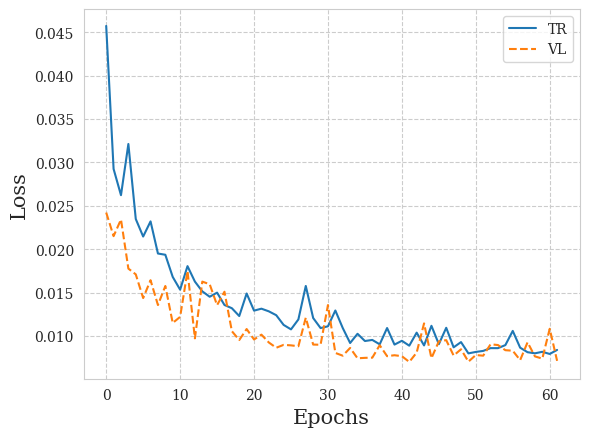

In [75]:
plot_loss(history.history['loss'], history.history['val_loss'])

In [76]:
y_pred = model.predict(X_val)
evaluate(y_val, y_pred)

12/12 [==============================] - 0s 3ms/step


{'rho': SignificanceResult(statistic=0.9038320709649166, pvalue=2.942103787517731e-136),
 'r_squared': 0.8930928362353885,
 'mse': 0.007130410536255456,
 'mae': 0.0488056150024674}

In [77]:
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

20/20 [==============================] - 0s 2ms/step


{'rho': SignificanceResult(statistic=0.8954473992315688, pvalue=8.592982115669832e-221),
 'r_squared': 0.848437030311346,
 'mse': 0.008027983536571545,
 'mae': 0.05661839449557991}

### III

In [71]:
# function to be passed to scikeras wrapper
def build_fn(n_hidden_units1, n_hidden_units2, n_hidden_units3, hidden_activation, learning_rate, initializer, output_activation, dropout_rate, seed): 
    keras.backend.clear_session()
    set_seed(seed)

    model = Sequential()
    model.add(Dense(n_hidden_units1, 
                    activation = hidden_activation, 
                    input_shape = (X_train.shape[1],),
                    kernel_initializer = initializer))
    model.add(Dense(n_hidden_units2, 
                    activation = hidden_activation,
                    kernel_initializer = initializer))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_hidden_units3, 
                    activation = hidden_activation,
                    kernel_initializer = initializer))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, 
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = Adam(learning_rate=learning_rate),
                  loss = "mse",
                  metrics = ["mean_squared_error"])
    return model

In [72]:
# randomized search
model = KerasRegressor(build_fn,
                       hidden_activation = "sigmoid",
                       initializer="glorot_normal",
                       output_activation="linear",
                       batch_size=32,
                       verbose=0
                       )

param_grid = {'model__n_hidden_units1': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__n_hidden_units2': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__n_hidden_units3': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.001, .01, .1, 1],
              'model__dropout_rate': [.2, .4, .6, .8],
              'model__seed': random.sample(range(100), 100),
              'epochs': [10, 20, 50, 100, 200]
              
              }

search = RandomizedSearchCV(model, 
                            param_grid, 
                            cv=KFold(3, shuffle=True, random_state=42), 
                            verbose=1,
                            n_iter=30,
                            n_jobs=-1,
                            scoring='r2')

search.fit(X_train, y_train, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best score: 0.7112459719377089 
Best params {'model__seed': 34, 'model__n_hidden_units3': 2, 'model__n_hidden_units2': 64, 'model__n_hidden_units1': 64, 'model__learning_rate': 0.01, 'model__dropout_rate': 0.2, 'epochs': 50}


In [66]:
keras.backend.clear_session()
set_seed(82)

model = Sequential()
model.add(Dense(16, 
                activation = "sigmoid", 
                input_shape = (X_train.shape[1],),
                kernel_initializer = "glorot_normal"))
model.add(Dense(256, 
                activation = "sigmoid", 
                kernel_initializer = "glorot_normal"))
model.add(Dropout(0.2))
model.add(Dense(64, 
                activation = "sigmoid", 
                kernel_initializer = "glorot_normal"))
model.add(Dropout(0.2))
model.add(Dense(1, 
                activation = "linear",
                kernel_initializer = "glorot_normal"))

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = "mse",
              metrics = ["mean_squared_error"])

In [67]:
es = EarlyStopping(monitor='val_loss', patience=20, verbose=True)

history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/200
46/46 [==============================] - 1s 12ms/step - loss: 0.1486 - mean_squared_error: 0.1486 - val_loss: 0.0821 - val_mean_squared_error: 0.0821
Epoch 2/200
46/46 [==============================] - 0s 6ms/step - loss: 0.0949 - mean_squared_error: 0.0949 - val_loss: 0.0691 - val_mean_squared_error: 0.0691
Epoch 3/200
46/46 [==============================] - 0s 5ms/step - loss: 0.0740 - mean_squared_error: 0.0740 - val_loss: 0.0628 - val_mean_squared_error: 0.0628
Epoch 4/200
46/46 [==============================] - 0s 6ms/step - loss: 0.0678 - mean_squared_error: 0.0678 - val_loss: 0.0623 - val_mean_squared_error: 0.0623
Epoch 5/200
46/46 [==============================] - 0s 5ms/step - loss: 0.0603 - mean_squared_error: 0.0603 - val_loss: 0.0499 - val_mean_squared_error: 0.0499
Epoch 6/200
46/46 [==============================] - 0s 6ms/step - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 7/200
46/46 [==============

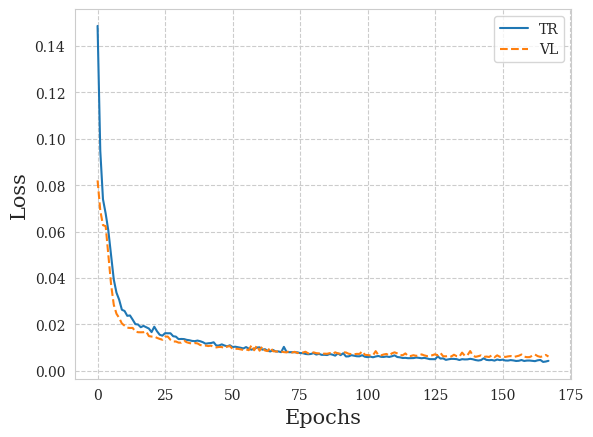

In [68]:
plot_loss(history.history['loss'], history.history['val_loss'])

In [69]:
y_pred = model.predict(X_val)
evaluate(y_val, y_pred)

12/12 [==============================] - 0s 2ms/step


{'rho': SignificanceResult(statistic=0.9065032605915099, pvalue=2.2472737334100776e-138),
 'r_squared': 0.9074374851491004,
 'mse': 0.006173662343230483,
 'mae': 0.04173193975030663}

In [70]:
y_pred = model.predict(X_test)
evaluate(y_pred, y_test)

20/20 [==============================] - 0s 1ms/step


{'rho': SignificanceResult(statistic=0.9025844727450145, pvalue=7.736736219604822e-230),
 'r_squared': 0.8393305374432108,
 'mse': 0.007625306757688016,
 'mae': 0.05121707040964766}

### IV

In [80]:
# function to be passed to scikeras wrapper
def build_fn(n_hidden_units1, n_hidden_units2, hidden_activation, learning_rate, initializer, output_activation, dropout_rate, seed): 
    keras.backend.clear_session()
    set_seed(seed)

    model = Sequential()
    model.add(Dense(n_hidden_units1, 
                    activation = hidden_activation, 
                    input_shape = (X_train.shape[1],),
                    kernel_initializer = initializer))
    model.add(Dense(n_hidden_units2, 
                    activation = hidden_activation,
                    kernel_initializer = initializer))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, 
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = Adam(learning_rate = learning_rate),
                  loss = "mse",
                  metrics = ["mean_squared_error"])
    return model

In [81]:
# randomized search
model = KerasRegressor(build_fn,
                       hidden_activation = "sigmoid",
                       initializer="glorot_normal",
                       output_activation="linear",
                       batch_size=32,
                       verbose=0
                       )

param_grid = {'model__n_hidden_units1': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__n_hidden_units2': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.01, .001, .1, 1],
              'model__dropout_rate': [.2, .4, .6, .8],
              'model__seed': random.sample(range(100), 100),
              'epochs': [10, 20, 50, 100, 200]
              
              }

search = RandomizedSearchCV(model, 
                            param_grid, 
                            cv=KFold(3, shuffle=True, random_state=42), 
                            verbose=1,
                            n_iter=50,
                            n_jobs=-1,
                            scoring='r2')

search.fit(X_train, y_train, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best score: 0.8805524772782354 
Best params {'model__seed': 10, 'model__n_hidden_units2': 64, 'model__n_hidden_units1': 128, 'model__learning_rate': 0.001, 'model__dropout_rate': 0.4, 'epochs': 200}


In [87]:
keras.backend.clear_session()
set_seed(10)

model = Sequential()
model.add(Dense(128, 
                activation = "sigmoid", 
                input_shape = (X_train.shape[1],),
                kernel_initializer = "glorot_normal"))
model.add(Dense(64, 
                activation = "sigmoid", 
                kernel_initializer = "glorot_normal"))
model.add(Dropout(0.4))
model.add(Dense(1, 
                activation = "linear",
                kernel_initializer = "glorot_normal"))

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = "mse",)

In [88]:
es = EarlyStopping(monitor='val_loss', patience=20, verbose=True)

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/500
46/46 [==============================] - 1s 7ms/step - loss: 0.3214 - val_loss: 0.0570
Epoch 2/500
46/46 [==============================] - 0s 3ms/step - loss: 0.1229 - val_loss: 0.0572
Epoch 3/500
46/46 [==============================] - 0s 3ms/step - loss: 0.0802 - val_loss: 0.0486
Epoch 4/500
46/46 [==============================] - 0s 4ms/step - loss: 0.0667 - val_loss: 0.0433
Epoch 5/500
46/46 [==============================] - 0s 4ms/step - loss: 0.0562 - val_loss: 0.0373
Epoch 6/500
46/46 [==============================] - 0s 4ms/step - loss: 0.0508 - val_loss: 0.0333
Epoch 7/500
46/46 [==============================] - 0s 4ms/step - loss: 0.0422 - val_loss: 0.0317
Epoch 8/500
46/46 [==============================] - 0s 3ms/step - loss: 0.0389 - val_loss: 0.0289
Epoch 9/500
46/46 [==============================] - 0s 3ms/step - loss: 0.0368 - val_loss: 0.0255
Epoch 10/500
46/46 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0252
Epoch 11/

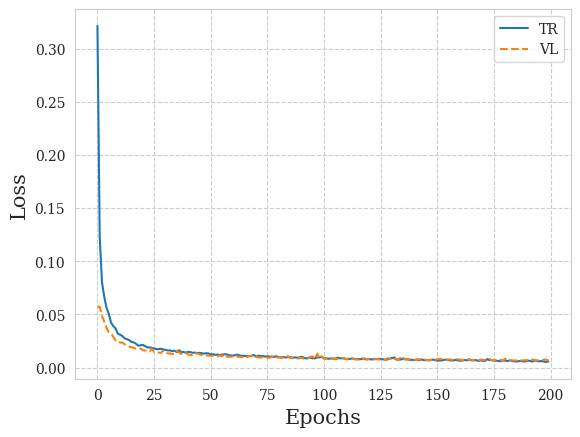

In [89]:
plot_loss(history.history['loss'], history.history['val_loss'])

In [90]:
y_pred = model.predict(X_val)
evaluate(y_val, y_pred)

12/12 [==============================] - 0s 2ms/step


{'rho': SignificanceResult(statistic=0.9084524516003688, pvalue=5.837749571370178e-140),
 'r_squared': 0.9006454719085849,
 'mse': 0.0066266707391803665,
 'mae': 0.050632158591686044}

In [91]:
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

20/20 [==============================] - 0s 2ms/step


{'rho': SignificanceResult(statistic=0.8975811440916864, pvalue=1.9956979254049705e-223),
 'r_squared': 0.8620260365334055,
 'mse': 0.007308201399462704,
 'mae': 0.0543293005249345}